In [3]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [4]:
#load the data
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
#we have the data splitted into features and target
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

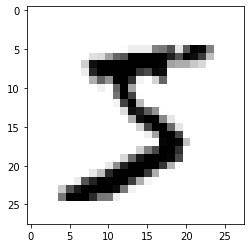

In [7]:
#plot of the features of a target
#this some_digit will be used later
some_digit = np.array(X.iloc[0])

some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')

In [8]:
y.iloc[0]

'5'

In [9]:
y = y.astype(int)
y.iloc[0]

5

In [10]:
#splitting into train and test set
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y[:60000], y[60000:]

In [11]:
#validate for 5s
y_train5 = (y_train == 5)
y_test5 = (y_test == 5)

In [12]:
#using a binary classifier, to predict 5's
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train5)

SGDClassifier(random_state=42)

In [13]:
#true for 5's, false for other
sgd_clf.predict([some_digit])

array([ True])

In [14]:
#cross validation scores for binary classifier of 5's
cross_val_score(sgd_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
#we can see that a random classifier is as good as sgd_clf
class Never5Classifier(BaseEstimator):
    def fit(self, X,y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [16]:
#use confussion matrix for more info about the classifier results
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, n_jobs=-1)

confusion_matrix(y_train5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
#better to calculate each metric, 

print("precission:", precision_score(y_train5, y_train_pred))

print("recall:", recall_score(y_train5, y_train_pred))


print("f1_score:", f1_score(y_train5, y_train_pred))

precission: 0.8370879772350012
recall: 0.6511713705958311
f1_score: 0.7325171197343846


In [18]:
#in some cases is important to make a trade-off between recall and precission, depends of the situation
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
#setting a threshold of 0, the model predict true
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
#setting a threshold of 8000, the model now predict false
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_train5, y_scores)

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recalls")

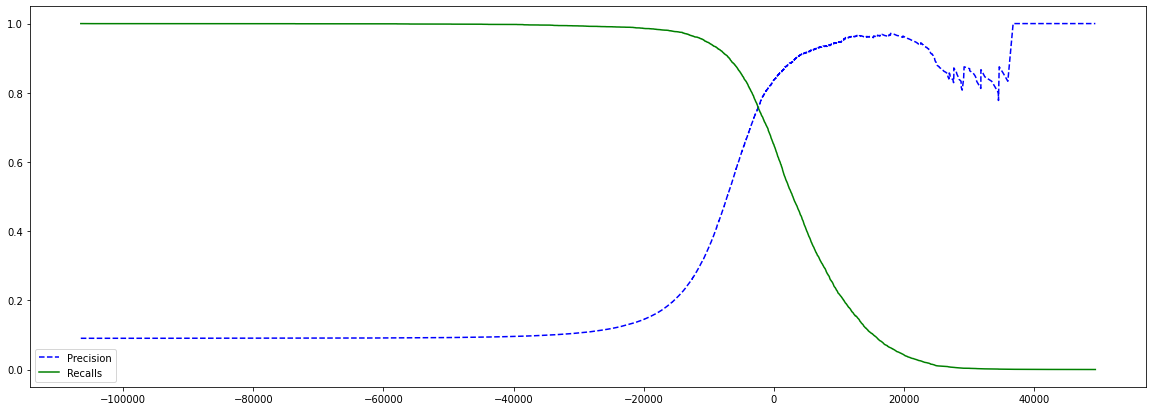

In [24]:
#here we can see the trade-off
plt.figure(figsize=(20,7))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'r-',)
    plt.xlabel('Recall')
    plt.ylabel('Precision')

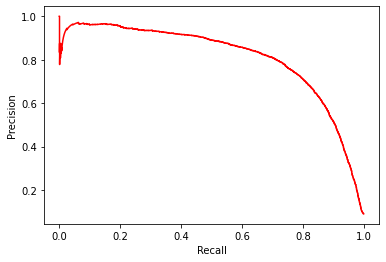

In [26]:
#here you can see directly the precision vs recall
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [27]:
#you can see the threshold for a specific value of precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.019499143958

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [29]:
#we can see the precision request for that threshold
precision_score(y_train5, y_train_pred_90)

0.9000345901072293

In [30]:
#here we can see the recall in that fixed threshol
recall_score(y_train5, y_train_pred_90)

0.4799852425751706

In [31]:
#now we want to obtain the ROC curve, that plots the recall against the False positive rate
fpr, tpr, thresholds = roc_curve(y_train5, y_scores)

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid()
    plt.xlabel('False positive rate')
    plt.ylabel("True positive rate (Recall)")
    plt.title('ROC Curve')
    plt.legend()

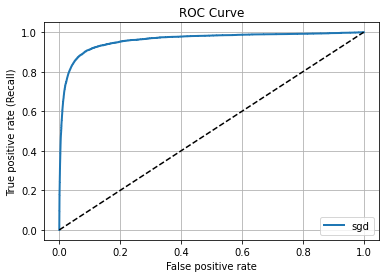

In [33]:
plot_roc_curve(fpr, tpr, "sgd")
plt.show()

In [34]:
# we can compute the AUC (Area under curve), a perfect clasifier will have an AUC of 1
roc_auc_score(y_train5, y_scores)

0.9604938554008616

In [35]:
#creating a new model for comparison, we will use the random forest classifier
forest_clf = RandomForestClassifier(random_state=42)

In [36]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train5, cv=3, method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [37]:
y_scores_forest = y_probas_forest[:,1]
frp_forest, tpr_forest, threshold_forest = roc_curve(y_train5, y_scores_forest)

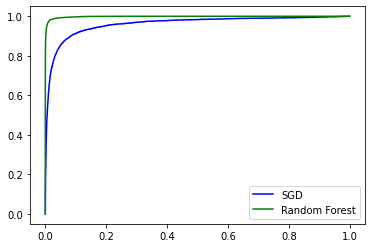

In [38]:
plt.plot(fpr, tpr, "b", label='SGD')
plt.plot(frp_forest, tpr_forest, "g", label='Random Forest')
plt.legend()
plt.show()

In [39]:
#the AUC for the random forest 
roc_auc_score(y_train5, y_scores_forest)

0.9983436731328145

Above we train and test binary classifier, now lets try with muticlass, multilabel and multioutput classification

In [ ]:
#lets try a Support vector machine classifier SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
"""
ovr_clf = OneVsRestClassifier(SVC(,))
ovr_clf.fit(X_train, y_train)
"""

'\novr_clf = OneVsRestClassifier(SVC(,))\novr_clf.fit(X_train, y_train)\n'

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3])

In [42]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [45]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])